# Task 2
## Conecta 4 con Temporal Difference Learning
### Integrantes:
- Diego Leiva
- Marta Ramirez
- Gustavo Gonzales
- Pablo Orellana

**Importar librerias necesarias**

In [108]:
from kaggle_environments import evaluate, make
import matplotlib.pyplot as plt
import numpy as np
import random
from random import choice
import gym
from tqdm.notebook import tqdm

**Crear un entorno de Conecta 4**

In [109]:
env = make("connectx", configuration={'timeout': 10}, debug=True)
env.render(mode="ipython")
env.configuration

{'timeout': 10, 'columns': 7, 'rows': 6, 'inarow': 4, 'steps': 1000}

### AGENTES MINIMAX

**AGENTE MINIMAX SIN PODA**

Definir funciones de evaluacion de ventana

In [110]:
def check_window(window, num_discs, piece, config):
    """
    Comprueba si una ventana contiene el número especificado de discos de una pieza dada.

    Args:
        window (list): La ventana a comprobar.
        num_discs (int): El número de discos en la ventana.
        piece (int): La pieza del jugador (1 o 2).
        config (Config): La configuración del juego.

    Returns:
        bool: Verdadero si la ventana contiene el número especificado de discos de la pieza dada, Falso en caso contrario.
    """
    if window.count(piece) == num_discs and window.count(0) == config.inarow - num_discs:
        return True
    else:
        return False 

In [111]:
def count_windows(grid, num_discs, piece, config):
    """
    Cuenta el número de ventanas en la cuadrícula que contienen cierto número de discos de una pieza dada.

    Args:
        grid (numpy.ndarray): La cuadrícula del juego.
        num_discs (int): El número de discos en una ventana.
        piece (int): La pieza del jugador (1 o 2).
        config (Config): La configuración del juego.

    Returns:
        int: El número de ventanas.
    """
    num_windows = 0

    # horizontal
    for row in range(config.rows):
        for col in range(config.columns - (config.inarow - 1)):
            window = list(grid[row, col:col + config.inarow])
            if check_window(window, num_discs, piece, config):
                num_windows += 1

    # vertical
    for row in range(config.rows - (config.inarow - 1)):
        for col in range(config.columns):
            window = list(grid[row:row + config.inarow, col])
            if check_window(window, num_discs, piece, config):
                num_windows += 1

    # diagonal con pendiente positiva
    for row in range(config.rows - (config.inarow - 1)):
        for col in range(config.columns - (config.inarow - 1)):
            window = list(grid[range(row, row + config.inarow), range(col, col + config.inarow)])
            if check_window(window, num_discs, piece, config):
                num_windows += 1

    # diagonal con pendiente negativa
    for row in range(config.inarow - 1, config.rows):
        for col in range(config.columns - (config.inarow - 1)):
            window = list(grid[range(row, row - config.inarow, -1), range(col, col + config.inarow)])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    return num_windows



Definir la heuristica a utilizar

In [112]:
def get_heuristic(grid, mark, config):
    """
    Calcula la puntuación heurística para un estado de cuadrícula dado.

    Args:
        grid (numpy.ndarray): La cuadrícula del juego.
        mark (int): La marca del jugador (1 o 2).
        config (Config): La configuración del juego.

    Returns:
        int: La puntuación heurística.
    """
    score = 0
    for i in range(config.inarow):
        num = count_windows(grid, i + 1, mark, config)
        score += (4 ** (i + 1)) * num
    for i in range(config.inarow):
        num_opp = count_windows(grid, i + 1, mark % 2 + 1, config)
        score -= (2 ** ((2 * i) + 3)) * num_opp
    return score


Definir funciones auxiliares

In [113]:
def drop_piece(grid, col, piece, config):
    """
    Inserta una pieza en la columna especificada de la cuadrícula del juego.

    Args:
        grid (numpy.ndarray): La cuadrícula del juego.
        col (int): La columna donde insertar la pieza.
        piece (int): La pieza del jugador (1 o 2).
        config (Config): La configuración del juego.

    Returns:
        numpy.ndarray: La cuadrícula del juego actualizada.
    """
    next_grid = grid.copy()
    for row in range(config.rows-1, -1, -1):
        if next_grid[row][col] == 0:
            break
    next_grid[row][col] = piece
    return next_grid

Implementar el algoritmo de minimax

In [114]:
def score_move_a(grid, col, mark, config, max_depth=1):
    """
    Calcula la puntuación para un movimiento en la cuadrícula del juego utilizando la función score_move_b.

    Args:
        grid (numpy.ndarray): La cuadrícula del juego.
        col (int): La columna en la que hacer el movimiento.
        mark (int): La marca del jugador (1 o 2).
        config (Config): La configuración del juego.
        max_depth (int, opcional): El número de pasos para mirar hacia adelante (Profundidad del arbol). Por defecto es 1.

    Returns:
        int: La puntuación para el movimiento.
    """
    next_grid = drop_piece(grid, col, mark, config)
    valid_moves = [col for col in range(config.columns) if next_grid[0][col] == 0]
    if len(valid_moves) == 0 or max_depth == 0:
        score = get_heuristic(next_grid, mark, config)
        return score
    else:
        scores = [score_move_b(next_grid, col, mark, config, max_depth - 1) for col in valid_moves]
        score = min(scores)
    return score


def score_move_b(grid, col, mark, config, max_depth):
    """
    Calcula la puntuación para un movimiento en la cuadrícula del juego utilizando la función score_move_a.

    Args:
        grid (numpy.ndarray): La cuadrícula del juego.
        col (int): La columna en la que hacer el movimiento.
        mark (int): La marca del jugador (1 o 2).
        config (Config): La configuración del juego.
        max_depth (int): El número de pasos a mirar hacia adelante (profundidad del arbol).

    Returns:
        int: La puntuación para el movimiento.
    """
    next_grid = drop_piece(grid, col, (mark % 2) + 1, config)
    valid_moves = [col for col in range(config.columns) if next_grid[0][col] == 0]
    if len(valid_moves) == 0 or max_depth == 0:
        score = get_heuristic(next_grid, mark, config)
        return score
    else:
        scores = [score_move_a(next_grid, col, mark, config, max_depth - 1) for col in valid_moves]
        score = max(scores)
    return score

**Definir el agente minimax**

In [115]:
def minimax_agent(obs, config):
    """
    Implementacion de un agente minimax sin poda para el juego conecta 4.

    Args:
        obs: Un objeto representando el estado actual del juego.
        config: Un objeto con los parametros de configuracion del juego.

    Returns:
        La columna que selecciono el agente para colocar su ficha.
    """
    valid_moves = [c for c in range(config.columns) if obs.board[c] == 0]
    grid = np.asarray(obs.board).reshape(config.rows, config.columns)
    scores = dict(zip(valid_moves, [score_move_a(grid=grid, col=col, mark=obs.mark, config=config, max_depth=1) for col in valid_moves]))
    max_cols = [key for key in scores.keys() if scores[key] == max(scores.values())]
    return random.choice(max_cols)

**Probar el funcionamiento del agenete contra un agente aleatorio**

Antes de hacer la prueba es necesario aclarar algunas cosas del entorno ConnectX de la API de Kaggle
1. el comando **'run'** lleva ["Jugador 1", "Jugador 2"]
2. Jugador 1 es representado por la ficha celeste con una 'K'
3. Jugador 2 es representado por la ficha gris con un 'pato'
4. El jugador 1 siempre va primero

In [116]:
# Usar el agente minimax contra un agente aleatorio
env.run([minimax_agent,"random"])

env.render(mode="ipython")

Claramente el agente minimax no tuvo problema alguno para vencer al agente aleatorio

Codigo de referencia obtenido de:
- https://www.kaggle.com/code/sidagar/getting-1000-score-using-only-minimax
- https://www.kaggle.com/code/alexisbcook/one-step-lookahead

**Evaluando el modelo**

In [117]:
def win_rate(rewards):
    """
    Calcula la tasa de victoria basada en una lista de recompensas.

    Args:
        rewards (lista): Una lista de tuplas que representan las recompensas para cada juego jugado. Cada tupla contiene dos valores: el número de victorias y el número de derrotas.

    Returns:
        tupla: Una tupla que contiene la tasa de victoria como porcentaje para victorias y derrotas.
    """
    return sum(r[0] for r in rewards) / float(len(rewards)) * 100, sum(r[1] for r in rewards) / float(len(rewards)) * 100 

In [118]:
def plot_win_count(win_rate1, agent1, win_rate2, agent2, episodes):
    """
    Grafica la cantidad de victorias de cada agente en el jeugo de conecta 4.

    Args:
        win_rate1 (float): Taza de exito del agente 1.
        agent1 (str): El nombre del agente 1.
        win_rate2 (float): Taza de exito del agente 2.
        agent2 (str): El nombre del agente 2.
        episodes (int): Cantidad total de iteraciones.

    Returns:
        None
    """
    # Calcula el conteo de victorias
    win_count1 = win_rate1 / 100 * episodes
    win_count2 = win_rate2 / 100 * episodes

    # Crea un gráfico de barras
    plt.bar([agent1, agent2], [win_count1, win_count2])
    plt.ylabel('Cantidad de Victorias')
    plt.title('Conteo de victorias para 2 agentes')

    # Muestra el gráfico
    plt.show()

In [119]:
# Mostrar los resultados
win_rate_1, win_rate_2 = win_rate(evaluate("connectx", [minimax_agent, "random"], num_episodes=10))
print("Taza de éxito para el agente Minimax: ", win_rate_1, "%")
print("Taza de éxito para el agente Aleatorio: ", win_rate_2, "%")

Taza de éxito para el agente Minimax:  100.0 %
Taza de éxito para el agente Aleatorio:  0.0 %


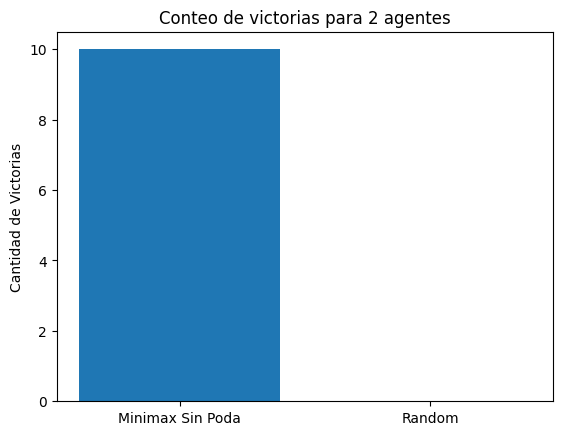

In [120]:
# Graficar los resultados
plot_win_count(win_rate_1, "Minimax Sin Poda", win_rate_2, "Random", 10)

In [121]:
# Mostrar los resultados
win_rate_1, win_rate_2 = win_rate(evaluate("connectx", [minimax_agent, "negamax"], num_episodes=10))
print("Taza de éxito para el agente Minimax: ", win_rate_1, "%")
print("Taza de éxito para el agente Negamax: ", win_rate_2, "%")

Taza de éxito para el agente Minimax:  95.0 %
Taza de éxito para el agente Negamax:  5.0 %


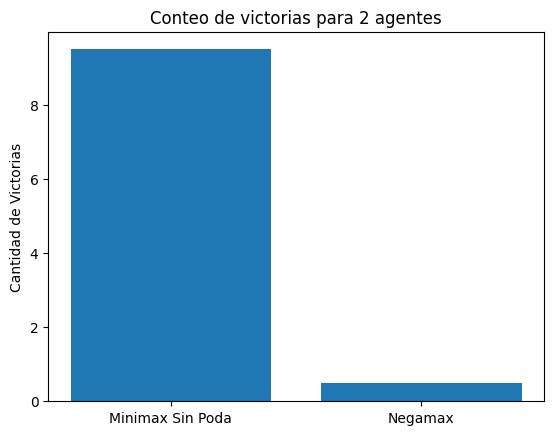

In [122]:
# Graficar los resultados
plot_win_count(win_rate_1, "Minimax Sin Poda", win_rate_2, "Negamax", 10)

**AGENTE MINIMAX CON ALPHA-BETA PRUNING**

Definir funciones auxiliares

In [123]:
def alpha_beta_drop_piece(grid, col, mark, config):
    """
    Realiza una jugada en el juego Connect 4 utilizando el algoritmo Alpha-Beta Pruning.

    Args:
    - grid: La cuadrícula actual del juego representada como una matriz.
    - col: La columna en la que se desea colocar la ficha.
    - mark: El marcador del jugador que realiza la jugada.
    - config: La configuración del juego.

    Returns:
    - next_grid: La cuadrícula resultante después de realizar la jugada.
    - (row, col): La posición de la ficha colocada en la cuadrícula.

    """
    next_grid = grid.copy()
    for row in range(config.rows-1, -1, -1):
        if next_grid[row][col] == 0:
            break
    next_grid[row][col] = mark
    return next_grid, (row, col)


Definir funciones de evaluacion de ventanas

In [124]:
def alpha_beta_check_window(window, piece, config):
    """
    Verifica si una ventana dada contiene una combinación ganadora para una pieza específica utilizando el algoritmo alpha-beta pruning.

    Args:
    - window (list): La ventana a verificar.
    - piece (int): La pieza para la cual se busca una combinación ganadora.
    - config (dict): La configuración actual del juego.

    Returns:
    - int: El número de veces que la pieza aparece en la ventana si no hay una combinación ganadora, o -1 si hay una combinación ganadora para la pieza contraria.

    """
    if window.count((piece%2)+1)==0:
        return window.count(piece)
    else:
        return -1

def alpha_beta_count_windows(grid, piece, config):
    """
    Cuenta el número de ventanas de fichas consecutivas en el tablero utilizando el algoritmo alpha-beta pruning.

    Args:
    - grid: numpy.ndarray
        El tablero de juego representado como una matriz numpy.
    - piece: int
        El valor de la ficha del jugador actual.
    - config: Config
        La configuración del juego.

    Returns:
    - num_windows: numpy.ndarray
        Un arreglo que contiene el número de ventanas de fichas consecutivas encontradas en el tablero.
        El índice i del arreglo representa el número de fichas consecutivas en una ventana.
        El valor en la posición i del arreglo representa la cantidad de ventanas encontradas con i fichas consecutivas.
    """
    num_windows = np.zeros(config.inarow+1)
    # horizontal
    for row in range(config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[row, col:col+config.inarow])
            type_window = alpha_beta_check_window(window, piece, config)
            if type_window != -1:
                num_windows[type_window] += 1

    # vertical
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns):
            window = list(grid[row:row+config.inarow, col])
            type_window = alpha_beta_check_window(window, piece, config)
            if type_window != -1:
                num_windows[type_window] += 1

    # diagonal con pendiente positiva
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row+config.inarow), range(col, col+config.inarow)])
            type_window = alpha_beta_check_window(window, piece, config)
            if type_window != -1:
                num_windows[type_window] += 1

    # diagonal con pendiente negativa
    for row in range(config.inarow-1, config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row-config.inarow, -1), range(col, col+config.inarow)])
            type_window = alpha_beta_check_window(window, piece, config)
            if type_window != -1:
                num_windows[type_window] += 1
    return num_windows


def count_windows_optimised(grid, piece, config, row, col):
    """
    Cuenta el número de ventanas de fichas consecutivas en un tablero de Connect 4.

    Args:
    - grid: numpy.ndarray, el tablero de juego.
    - piece: int, el valor de la ficha (1 o 2).
    - config: Config, la configuración del juego.
    - row: int, la fila actual.
    - col: int, la columna actual.

    Returns:
    - num_windows: numpy.ndarray, un arreglo con la cantidad de ventanas de fichas consecutivas encontradas.
    """
    num_windows = np.zeros(config.inarow+1)
    # horizontal
    for acol in range(max(0,col-(config.inarow-1)),min(col+1,(config.columns-(config.inarow-1)))):
        window = list(grid[row, acol:acol+config.inarow])
        type_window = alpha_beta_check_window(window, piece, config)
        if type_window != -1:
            num_windows[type_window] += 1

    # vertical
    for arow in range(max(0,row-(config.inarow-1)),min(row+1,(config.rows-(config.inarow-1)))):
        window = list(grid[arow:arow+config.inarow, col])
        type_window = alpha_beta_check_window(window, piece, config)
        if type_window != -1:
            num_windows[type_window] += 1

    # diagonal con pendiente positiva
    for arow, acol in zip(range(row-(config.inarow-1),row+1),range(col-(config.inarow-1),col+1)):
        if (arow>=0 and acol>=0 and arow<=(config.rows-config.inarow) and acol<=(config.columns-config.inarow)):
            window = list(grid[range(arow, arow+config.inarow), range(acol, acol+config.inarow)])
            type_window = alpha_beta_check_window(window, piece, config)
            if type_window != -1:
                num_windows[type_window] += 1

    # diagonal con pendiente negativa
    for arow,acol in zip(range(row,row+config.inarow),range(col,col-config.inarow,-1)):
        if (arow >= (config.inarow-1) and acol >=0 and arow <= (config.rows-1) and acol <= (config.columns-config.inarow)):
            window = list(grid[range(arow, arow-config.inarow, -1), range(acol, acol+config.inarow)])
            type_window = alpha_beta_check_window(window, piece, config)
            if type_window != -1:
                num_windows[type_window] += 1
    return num_windows

Definir heuristicas optimizadas con poda

In [125]:
def alpha_beta_get_heuristic(grid, mark, config):
    """
    Calcula la heurística para una cuadrícula dada en el juego Connect 4 utilizando el algoritmo Alpha-Beta Pruning.

    Args:
    - grid: La cuadrícula del juego Connect 4.
    - mark: El marcador del jugador actual.
    - config: La configuración del juego Connect 4.

    Returns:
    - score: El valor de la heurística calculada para la cuadrícula dada.

    La heurística se calcula contando el número de ventanas de fichas consecutivas para el jugador actual y el oponente.
    Luego, se asigna un puntaje a cada ventana y se suma o resta al puntaje total dependiendo del jugador.
    Si el jugador actual tiene una ventana ganadora, se retorna infinito positivo.
    Si el oponente tiene una ventana ganadora, se retorna infinito negativo.
    """
    score = 0
    num = alpha_beta_count_windows(grid, mark, config)
    for i in range(config.inarow):
        if (i == (config.inarow - 1) and num[i + 1] >= 1):
            return float("inf")
        score += (4 ** (i)) * num[i + 1]
    num_opp = alpha_beta_count_windows(grid, mark % 2 + 1, config)
    for i in range(config.inarow):
        if (i == (config.inarow - 1) and num_opp[i + 1] >= 1):
            return float("-inf")
        score -= (2 ** ((2 * i) + 1)) * num_opp[i + 1]
    return score


def get_heuristic_optimised(grid, next_grid, mark, config, row, col, start_score):
    """
    Calcula la heurística optimizada para evaluar un movimiento en el juego Connect 4.

    Args:
    - grid: La cuadrícula actual del juego.
    - next_grid: La cuadrícula después de realizar el movimiento.
    - mark: El jugador que realiza el movimiento.
    - config: La configuración del juego.
    - row: La fila del movimiento.
    - col: La columna del movimiento.
    - start_score: El puntaje inicial.

    Returns:
    - score: El puntaje de la heurística optimizada.
    """
    score = 0
    num1 = count_windows_optimised(grid,mark,config,row,col)
    num2 = count_windows_optimised(next_grid,mark,config,row,col)
    for i in range(config.inarow):
        if (i==(config.inarow-1) and (num2[i+1]-num1[i+1]) >= 1):
            return float("inf")
        score += (4**(i))*(num2[i+1]-num1[i+1])
    num1_opp = count_windows_optimised(grid,mark%2+1,config,row,col)
    num2_opp = count_windows_optimised(next_grid,mark%2+1,config,row,col)
    for i in range(config.inarow): 
        if (i==(config.inarow-1) and num2_opp[i+1]-num1_opp[i+1]  >= 1):
            return float ("-inf")     
        score-= (2**((2*i)+1))*(num2_opp[i+1]-num1_opp[i+1])
    score+= start_score
    return score

Aplicar minimax con poda alpha-beta

In [126]:
def alpha_beta_score_move_a(grid, col, mark, config, start_score, n_steps):
    """
    Calcula la puntuación de una jugada utilizando el algoritmo de poda alfa-beta.

    Args:
    - grid: La cuadrícula actual del juego.
    - col: La columna en la que se desea soltar la ficha.
    - mark: El marcador del jugador actual.
    - config: La configuración del juego.
    - start_score: La puntuación inicial.
    - n_steps: El número de pasos restantes para explorar.

    Returns:
    - La puntuación de la jugada.

    """
    next_grid, pos = alpha_beta_drop_piece(grid, col, mark, config)
    row, col = pos
    score = get_heuristic_optimised(grid,next_grid,mark,config, row, col,start_score)
    valid_moves = [col for col in range (config.columns) if next_grid[0][col]==0]
    
    # Dado que acabamos de soltar nuestra pieza, solo existe la posibilidad de que nosotros obtengamos 4 en fila y no el oponente.
    # Por lo tanto, la puntuación solo puede ser +infinito.
    scores = []
    if len(valid_moves)==0 or n_steps ==0 or score == float("inf"):
        return score
    else :
        for col in valid_moves:
            current = alpha_beta_score_move_b(next_grid,col,mark,config,score,n_steps-1)
            scores.append(current)
        score = min(scores)
    return score


def alpha_beta_score_move_b(grid, col, mark, config, start_score, n_steps):
    """
    Calcula la puntuación de un movimiento utilizando el algoritmo de poda alfa-beta.
    
    Args:
    - grid: matriz que representa el estado actual del juego.
    - col: columna en la que se desea soltar la pieza.
    - mark: marca del jugador actual.
    - config: objeto de configuración del juego.
    - start_score: puntuación inicial del movimiento.
    - n_steps: número de pasos restantes para explorar en el árbol de búsqueda.
    
    Returns:
    - score: puntuación del movimiento.
    """
    next_grid, pos = alpha_beta_drop_piece(grid,col,(mark%2)+1,config)
    row, col = pos
    score = get_heuristic_optimised(grid,next_grid,mark,config, row, col,start_score)
    valid_moves = [col for col in range (config.columns) if next_grid[0][col]==0]
    
    # Dado que acabamos de soltar la pieza del oponente, solo existe la posibilidad de que el oponente consiga 4 en fila y no nosotros.
    # Por lo tanto, la puntuación solo puede ser -infinito.
    scores = []
    if len(valid_moves)==0 or n_steps ==0 or score == float ("-inf"):
        return score
    else :
        for col in valid_moves:
            current = alpha_beta_score_move_a (next_grid,col,mark,config,score,n_steps-1)
            scores.append(current)
        score = max(scores)
    return score

**Definir el agente Minimax Con Alpha-Beta Pruning**

In [127]:
def minimax_agent_alpha_beta(obs, config):
    """
    Agente que utiliza el algoritmo Minimax con poda alfa-beta para tomar decisiones en el juego Connect 4.

    Args:
    - obs: Objeto que contiene el estado actual del juego.
    - config: Objeto que contiene la configuración del juego.

    Returns:
    - La columna seleccionada por el agente para realizar su movimiento.
    """
    grid = np.asarray(obs.board).reshape(config.rows, config.columns)
    valid_moves = [c for c in range(config.columns) if grid[0][c] == 0]
    scores = {}
    start_score = alpha_beta_get_heuristic(grid, obs.mark, config)
    for col in valid_moves:
        scores[col] = alpha_beta_score_move_a(grid, col, obs.mark, config,start_score,2)
    max_cols = [key for key in scores.keys() if scores[key] == max(scores.values())]
    return random.choice(max_cols)

**Probar el agente minimax con poda alpha-beta contra un agente aleatorio**

In [128]:
env.reset()

# Usar el agente minimax contra un agente aleatorio
env.run([minimax_agent_alpha_beta,"random"])

env.render(mode="ipython")

**Evaluando el Modelo**

In [129]:
# Mostrar los resultados
win_rate_1, win_rate_2 = win_rate(evaluate("connectx", [minimax_agent_alpha_beta, "random"], num_episodes=10))
print("Taza de éxito para el agente Minimax Alpha-Beta: ", win_rate_1, "%")
print("Taza de éxito para el agente Aleatorio: ", win_rate_2, "%")

Taza de éxito para el agente Minimax Alpha-Beta:  100.0 %
Taza de éxito para el agente Aleatorio:  0.0 %


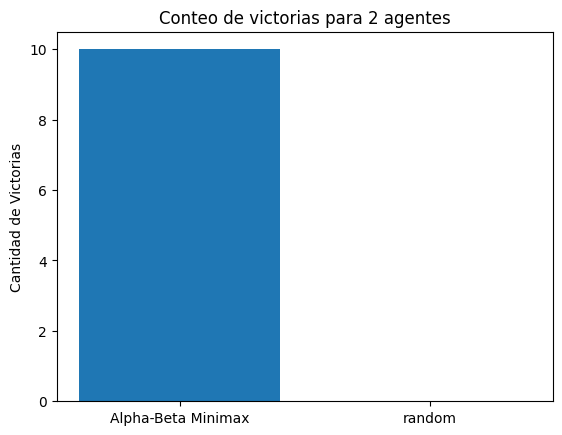

In [130]:
# Graficar los resultados
plot_win_count(win_rate_1, "Alpha-Beta Minimax", win_rate_2, "random", 10)

In [131]:
# Mostrar los resultados
win_rate_1, win_rate_2 = win_rate(evaluate("connectx", [minimax_agent_alpha_beta, "negamax"], num_episodes=10))
print("Taza de éxito para el agente Minimax Alpha-Beta: ", win_rate_1, "%")
print("Taza de éxito para el agente Aleatorio: ", win_rate_2, "%")

Taza de éxito para el agente Minimax Alpha-Beta:  100.0 %
Taza de éxito para el agente Aleatorio:  0.0 %


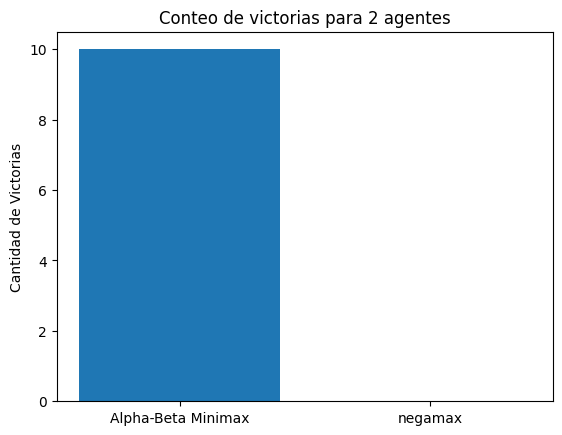

In [132]:
# Graficar los resultados
plot_win_count(win_rate_1, "Alpha-Beta Minimax", win_rate_2, "negamax", 10)

# Q learning

In [133]:
class ConnectX(gym.Env):
    def __init__(self, switch_prob=0.5):
        self.env = env
        self.pair = [None, 'negamax']
        self.trainer = self.env.train(self.pair)
        self.switch_prob = switch_prob
        
        # Define required gym fields (examples):
        config = self.env.configuration
        self.action_space = gym.spaces.Discrete(config.columns)
        self.observation_space = gym.spaces.Discrete(config.columns * config.rows)

    def switch_trainer(self):
        self.pair = self.pair[::-1]
        self.trainer = self.env.train(self.pair)

    def step(self, action):
        return self.trainer.step(action)
    
    def reset(self):
        if random.uniform(0, 1) < self.switch_prob:
            self.switch_trainer()
        return self.trainer.reset()
    
    def render(self, **kwargs):
        return self.env.render(**kwargs)


class QTable:
    def __init__(self, action_space):
        self.table = dict()
        self.action_space = action_space
        
    def add_item(self, state_key):
        self.table[state_key] = list(np.zeros(self.action_space.n))
        
    def __call__(self, state):
        board = state['board'][:] # Get a copy
        board.append(state.mark)
        state_key = np.array(board).astype(str)
        state_key = hex(int(''.join(state_key), 3))[2:]
        if state_key not in self.table.keys():
            self.add_item(state_key)
        
        return self.table[state_key]

In [134]:
env = ConnectX()

### Hyper parameters

In [135]:
alpha = 0.1
gamma = 0.6
epsilon = 0.99
min_epsilon = 0.1

episodes = 100

alpha_decay_step = 1000
alpha_decay_rate = 0.9
epsilon_decay_rate = 0.9999

In [136]:
q_table = QTable(env.action_space)

all_epochs = []
all_total_rewards = []
all_avg_rewards = [] # Last 100 steps
all_qtable_rows = []
all_epsilons = []

for i in tqdm(range(episodes)):
    state = env.reset()

    epsilon = max(min_epsilon, epsilon * epsilon_decay_rate)
    epochs, total_rewards = 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = choice([c for c in range(env.action_space.n) if state['board'][c] == 0])
        else:
            row = q_table(state)[:]
            selected_items = []
            for j in range(env.action_space.n):
                if state['board'][j] == 0:
                    selected_items.append(row[j])
                else:
                    selected_items.append(-1e7)
            action = int(np.argmax(selected_items))

        next_state, reward, done, info = env.step(action)

        # Apply new rules
        if done:
            if reward == 1: # Won
                reward = 20
            elif reward == 0: # Lost
                reward = -20
            else: # Draw
                reward = 10
        else:
            reward = -0.05 # Try to prevent the agent from taking a long move

        old_value = q_table(state)[action]
        next_max = np.max(q_table(next_state))
        
        # Update Q-value
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table(state)[action] = new_value

        state = next_state
        epochs += 1
        total_rewards += reward


    all_epochs.append(epochs)
    all_total_rewards.append(total_rewards)
    avg_rewards = np.mean(all_total_rewards[max(0, i-100):(i+1)])
    all_avg_rewards.append(avg_rewards)
    all_qtable_rows.append(len(q_table.table))
    all_epsilons.append(epsilon)

    if (i+1) % alpha_decay_step == 0:
        alpha *= alpha_decay_rate

  0%|          | 0/100 [00:00<?, ?it/s]

In [137]:
tmp_dict_q_table = q_table.table.copy()
dict_q_table = dict()

for k in tmp_dict_q_table:
    if np.count_nonzero(tmp_dict_q_table[k]) > 0:
        dict_q_table[k] = int(np.argmax(tmp_dict_q_table[k]))

In [138]:
def q_learning_agent(observation, configuration):

    q_table = {'1d':0,'5d2':0,'1d32d':4,'1':4,'892':0,'3bdd':0,'1b62104':5,'53':0,'242':0,'107f':1,'94bb6c':0,'c56315':0,'37c':0,'1dbf45':0,'1dbf5a':0,'1e593b':0,'1c579906':0,'1607b6b493':2,'5':1,'116c':0,'30bf':0,'30fe':0,'1198d':1,'16e02ea':1,'64':0,'56875':0,'2e34d7ea':0,'18abae12d33':6,'b':0,'1f4':0,'56f':0,'1f46':0,'e079a7':2,'310':0,'325':0,'1b6019c':0,'1b60331':1,'e9e9ffbee':1,'7ce5216ff28d':5,'106':1,'a357':0,'323718a':0,'323778d':0,'15ee825fde':0,'c8030fef7b7817d':0,'c8030fef7bce98e':0,'c8030ff0ee4b2b9':2,'a6':0,'2e7e3':0,'2edb0':0,'2f0d02ad':0,'ecbf6f3d2':1,'19958a351a3':1,'7e6fdb734842':1,'a80f211c9957':0,'dd2aee5591662':0,'384b641f9de9b613':0,'384b641f9df39f56':0,'384b64a329df96db':0,'384b64a3f9b44c32':5}

    board = observation['board'][:]
    board.append(observation['mark'])
    state_key = list(map(str, board))
    state_key = hex(int(''.join(state_key), 3))[2:]

    if state_key not in q_table.keys():
        return choice([c for c in range(configuration['columns']) if observation['board'][c] == 0])

    action = q_table[state_key]

    if observation.board[action] != 0:
        return choice([c for c in range(configuration['columns']) if observation['board'][c] == 0])

    return action
    

**Probar el agente con un modelo aleatorio**

In [139]:
env = make("connectx", configuration={'timeout': 10}, debug=True)

env.reset()

# Usar el agente minimax contra un agente aleatorio
env.run([q_learning_agent,"random"])

env.render(mode="ipython")

**Evaluar el modelo**

In [140]:
# Mostrar los resultados
win_rate_1, win_rate_2 = win_rate(evaluate("connectx", [q_learning_agent, "random"], num_episodes=10))
print("Taza de éxito para el agente Q-Learning: ", win_rate_1, "%")
print("Taza de éxito para el agente Aleatorio: ", win_rate_2, "%")

Taza de éxito para el agente Q-Learning:  20.0 %
Taza de éxito para el agente Aleatorio:  80.0 %


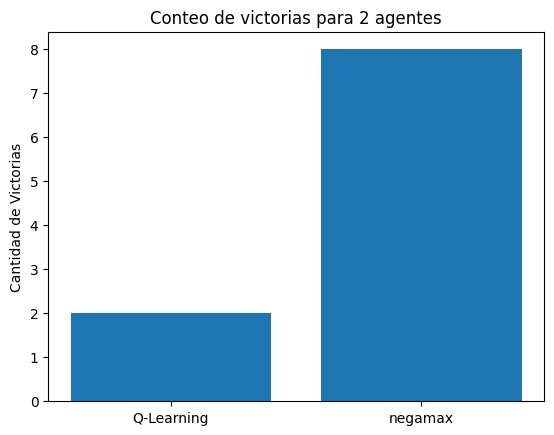

In [141]:
# Graficar los resultados
plot_win_count(win_rate_1, "Q-Learning", win_rate_2, "negamax", 10)

In [142]:
# Mostrar los resultados
win_rate_1, win_rate_2 = win_rate(evaluate("connectx", [q_learning_agent, "negamax"], num_episodes=10))
print("Taza de éxito para el agente Q-Learning: ", win_rate_1, "%")
print("Taza de éxito para el agente Negamax: ", win_rate_2, "%")

Taza de éxito para el agente Q-Learning:  0.0 %
Taza de éxito para el agente Negamax:  100.0 %


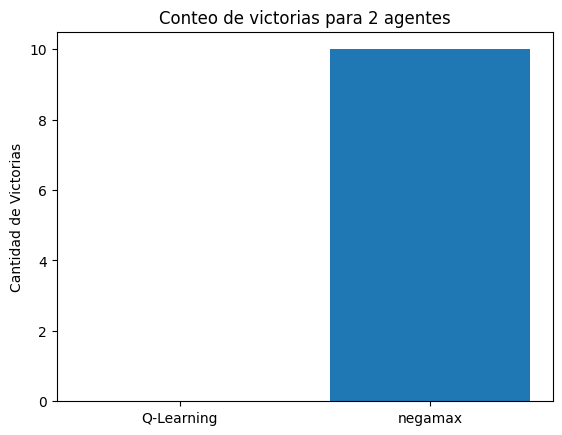

In [143]:
# Graficar los resultados
plot_win_count(win_rate_1, "Q-Learning", win_rate_2, "negamax", 10)